# Fit S(Q)

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve using the S(Q) generated by pre-trained cVAE model
# Infer potential parameters from optimized latent variables using GPR
# tensorflow 2.6.0
# sklearn 0.24.2

## Setup

In [2]:
fit_SQ = 0

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter

import tensorflow as tf
print(tf. __version__)

2.10.0


## Load data

In [4]:
W = 10

In [5]:
import os
data_path = './fwdexternalsilica/'
filename_0 = '{}_600.dat'.format(W)
filename_1 = '{}_1100.dat'.format(W)
print(filename_0)
data_0 = np.genfromtxt(data_path + filename_0, skip_header=39, delimiter=[11,15,12,10])
data_1 = np.genfromtxt(data_path + filename_1, skip_header=39, delimiter=[11,15,12,10])

10_600.dat


In [6]:
Q_0 = data_0[:,0].astype(np.float32)
IQ_data_0 = data_0[:,1].astype(np.float32)
IQ_er_0 = data_0[:,2].astype(np.float32)
dQ_0 = data_0[:,3].astype(np.float32)
Q_1 = data_1[:,0].astype(np.float32)
IQ_data_1 = data_1[:,1].astype(np.float32)
IQ_er_1 = data_1[:,2].astype(np.float32)
dQ_1 = data_1[:,3].astype(np.float32)

Fit P(Q) to obtain the HS diameter

In [7]:
# fit P(Q)
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out # sampled on Q

def I_P(sigma, A, I_inc):
    P = hardsphere(Q_1,sigma=sigma)
    Q_fine = Q_1
    P_res = IQ_resoln(Q_1,Q_fine,P,dQ_1*1.8)
    return A*P_res + I_inc

def lambda_P(fp):
    sigma = fp[0] 
    A = fp[1] 
    I_inc = fp[2]
    return np.sum((np.log(I_P(sigma, A, I_inc)) - np.log(IQ_data_1))[Q_1>1e-2]**2)
    

In [8]:
Q_0 = 9e-3
sigma_0 = 4.5*2/Q_0
A_0 = 4e4
I_inc_0 = 1.5
x0 = [sigma_0, A_0, I_inc_0]
lb = [sigma_0*0.5, A_0*0.5, I_inc_0*0.5]
ub = [sigma_0*1.5, A_0*1.5, I_inc_0*1.5]
x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))
opti_P = opt.minimize(lambda_P, x0=np.array(x0), 
                      method='L-BFGS-B',
                      jac='3-point',
                      options={'maxiter':1000,'ftol':1e-9, 'gtol':1e-9},
                      )
fp_opt_P = opti_P.x
opti_P

      fun: 0.122693755
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.63807498e-06,  6.53923644e-06, -5.17893292e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 336
      nit: 21
     njev: 48
   status: 0
  success: True
        x: array([1.22090214e+03, 3.99986760e+04, 1.39432765e+00])

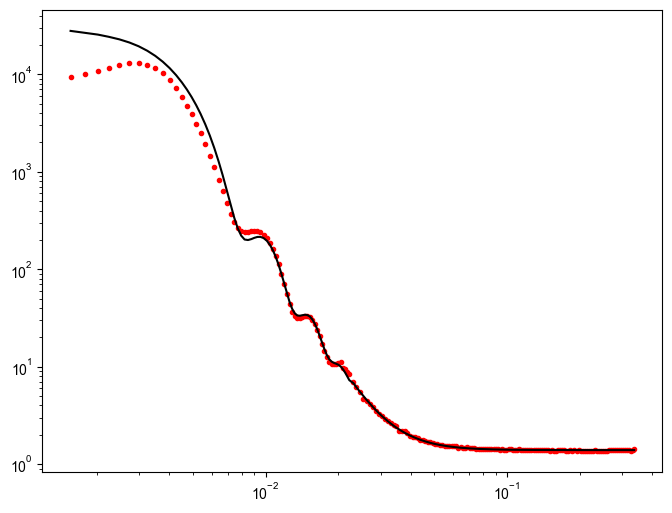

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(Q_1,IQ_data_1,'.r')
ax.plot(Q_1,I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]),'-k')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
plt.show()

In [10]:
## convert the input data to the same 80-D array as SQ-NN model
sq_dim = 80
sample_dim = 1

Rescale

In [11]:
## rescale the input data Q range
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2

'''
The input data is rescaled to the range such that 0.02<=QD<=16 
'''
r_HS_i = fp_opt_P[0]/2 # initial guess of r_HS when Q = 0.04112146, Qr_HS = 3 (first peak)
d_HS_i = r_HS_i*2
print('Initial guess of d_HS = {}'.format(d_HS_i))
IQ_rs = np.zeros((sample_dim,sq_dim)) 
Qd_HS = Q_1*d_HS_i

## rescale IQ to QD in [0,16]
f_IQ = interp.interp1d(Qd_HS[0:],IQ_data_1[0:],fill_value='extrapolate')
IQ_rs = f_IQ(q_rs).astype(np.float32)
IQ_rs[IQ_rs<=0] = 1e-5

## rescale IQ_er to QD in [0,16]
f_IQ_er = interp.interp1d(Qd_HS[0:],IQ_er_1[0:],fill_value='extrapolate')
IQ_er_rs = f_IQ_er(q_rs).astype(np.float32)

Initial guess of d_HS = 1220.9021415170337


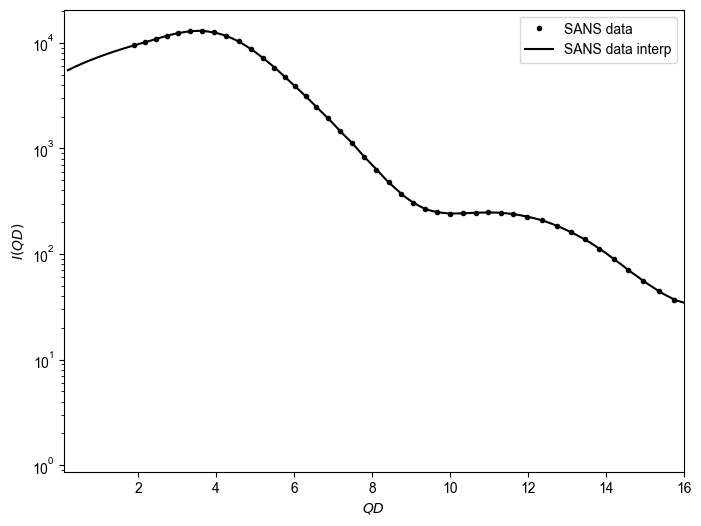

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(Qd_HS,IQ_data_1,'.k',label='SANS data')
ax.plot(q_rs,IQ_rs,'-k',label='SANS data interp')
ax.set_xlim([0.1,16])
# ax.set_ylim([0.1,30])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')
ax.legend()
plt.show()

### Resolution

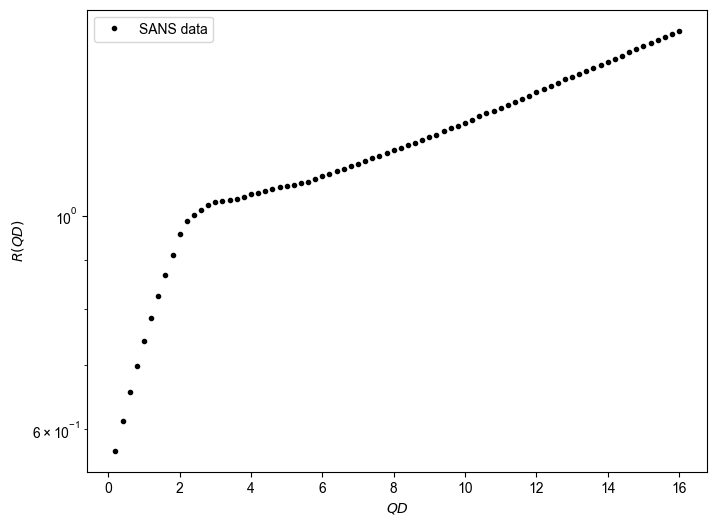

In [13]:
interpolating_function_dQ = interp.interp1d(Qd_HS,dQ_1*1.8*d_HS_i,fill_value='extrapolate',kind= 'linear')
dQ_interp = interpolating_function_dQ(q).astype(np.float32)
dQ_sm = sgnl.savgol_filter(dQ_interp,5,3)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q,dQ_sm,'.k',label='SANS data')
# ax.set_xlim([0,16])
# ax.set_ylim([5,2000])
ax.set_yscale('log')
ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$R(QD)$')
ax.legend()
plt.show()

## Define functions 

In [14]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
SQ_NN_GP = lambda x: SQ_NN(x,GP=True,lmbda=0.2)

In [15]:
def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_th(sq_func,fp):
    # form factor
    r_sigma = fp[3]
    P = hardsphere(q,sigma=r_sigma)

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P*fp_opt_P[1] + fp_opt_P[2]

    # resolution
    dQ = dQ_sm
    Q_fine = np.linspace(0.2,16,1000)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(q,IQ_res,r_sigma) 
    f_interp = interp.interp1d(q,IQ_res_scale)
    # I_scale(QD) = I(QD/fp[3]), 
    # if I_scale(QD) = I^(QD*), D*=D/fp[3], D = D*fp[3]
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp

## Pick an I(Q) and test

In [16]:
IQ_exp = IQ_rs

### Initial value

In [17]:
'''
Fitting parameters:
fp = [phi, kappa, A]

I(Q) = C*P(Q)*S(Q) + I_inc
rD: scaling parameter
'''

fp_i =       [0.16,  0.25,   15, 1.0]
fp_ubounds = (0.2,   0.6,   20, 1.3)
fp_lbounds = (0.02, 0.1,  0.5, 0.7)
fp_bounds_opt = opt.Bounds(lb=np.array(fp_lbounds), ub=np.array(fp_ubounds))
fp = fp_i

In [18]:
def Fit_loss(sq_func,fp):
    return (np.log(IQ_exp)-np.log(IQ_th(sq_func,fp)))[(q>=0)&(q<=16)]

def func_IQ_NN_err(fp):
    return np.mean((Fit_loss(SQ_NN,fp))**2)

def func_minimize(func, fp_fix, fp_x0, index_x, callback=False):
    '''
    func: regression loss to be minimized
    fp_fix: fixed parameters
    fp_x0: initial guess
    index_x: index of free fitting parameters
    
    '''
    index_fixed = np.array([x for x in np.arange(len(fp_fix)) if not x in index_x])

    def f(x,args):
        fp = fp_fix
        for i, index in enumerate(index_x):
            fp[index] = x[i]
        return func(fp)

    x_bounds = opt.Bounds(lb=np.array(fp_lbounds)[index_x], ub=np.array(fp_ubounds)[index_x])

    if len(index_fixed)==0:
        args_fixed = None
    else:
        args_fixed = np.array(fp_fix)[index_fixed]
    
    f_callback = None
    if callback:
        fp_history = []
        def f_callback(x):
            fp = fp_fix
            for i, index in enumerate(index_x):
                fp[index] = x[i]
            fp_history.append(x)
    
    opti = opt.minimize(f, x0=np.array(fp_x0)[index_x], args=args_fixed, 
                        method='L-BFGS-B',bounds=x_bounds,
                        jac='3-point',
                        options={'maxiter':2000,'ftol':1e-15, 'gtol':1e-15},
                        callback=f_callback
                        )
    
    if callback:
        return opti, fp_history
    else:
        return opti
    
def fit_err(opti, index_x, IQ_MSE=0.01):
    fp_opt = fp_i
    for i, index in enumerate(index_x):
        fp_opt[index] = opti.x[i]
        
    # https://stackoverflow.com/questions/43593592
    fp_opt_err = np.zeros(len(fp_opt))
    tmp_i = np.zeros(len(opti.x))
    for i, index in enumerate(index_x):
        tmp_i[i] = 1.0
        hess_inv_i = opti.hess_inv(tmp_i)[i]
        uncertainty_i = np.sqrt(max(1, abs(opti.fun)) * IQ_MSE * hess_inv_i)
        tmp_i[i] = 0.0
        fp_opt_err[index] = uncertainty_i
        
    return fp_opt, fp_opt_err

In [19]:
index_free=np.arange(4)
opti_NN, fp_history = func_minimize(func_IQ_NN_err, fp_fix=fp_i.copy(), fp_x0=fp_i.copy(), index_x=index_free, callback=True)

fp_opt_NN = fp_i.copy()
for i, index in enumerate(index_free):
    fp_opt_NN[index] = opti_NN.x[i]

In [20]:
fp_opt_NN, fp_err_NN = fit_err(opti_NN, index_free, IQ_MSE=0.01**2)

In [21]:
opti_NN

      fun: 0.06051166053025686
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00074245, -0.00181513,  0.00041949,  0.00159884])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 999
      nit: 30
     njev: 111
   status: 0
  success: True
        x: array([ 0.08118749,  0.19118553, 14.99782858,  1.02499654])

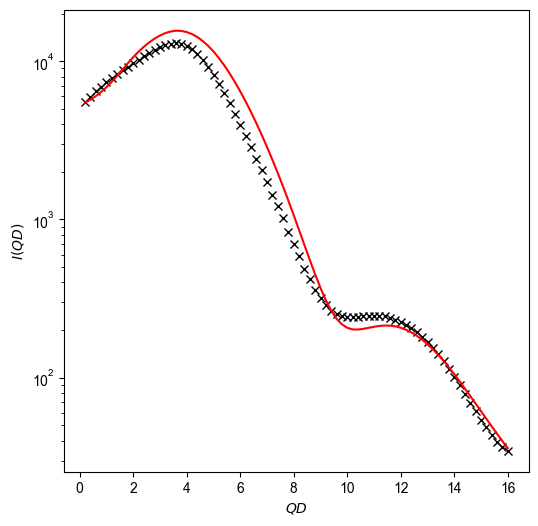

In [22]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

# ax.errorbar(q,IQ_rs,yerr=IQ_er_rs,fmt='k')
ax.plot(q,IQ_rs,'xk')
# ax.errorbar(q,IQ_rs,IQ_er_rs,color='k',capsize=2)
ax.plot(q,IQ_th(SQ_NN,fp_opt_NN),'-r')

ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')

# ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

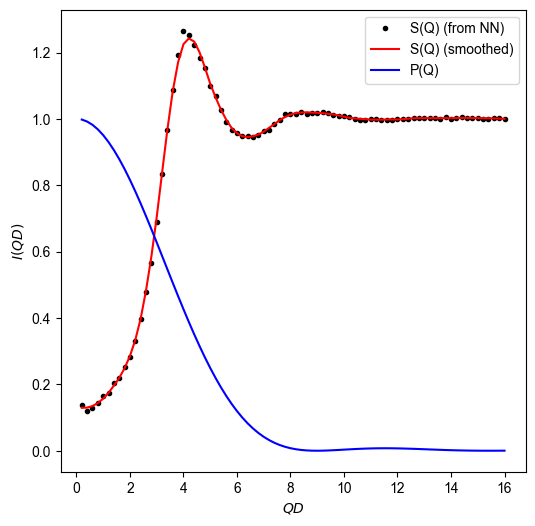

In [23]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q,SQ_th(SQ_NN,fp_opt_NN),'.k', label='S(Q) (from NN)')
SQ_th_sm = savgol_filter(SQ_th(SQ_NN,fp_opt_NN), 11,2)
ax.plot(q,SQ_th_sm,'-r', label='S(Q) (smoothed)')

ax.plot(q,hardsphere(q),'-b', label='P(Q)')

ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')

ax.legend()

# ax.set_yscale('log')
plt.show()

## Result potential parameters

In [24]:
dataname = str(W)
datapath = './results/'

## Result fitting parameters

In [25]:
def Z(A,kappa):
    return np.sqrt(A*(1+1/2/kappa)**2)  

def Z_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dZ_dA = (Z(A*(1+delta),kappa)-Z(A,kappa))/(A*delta)
    dZ_dkappa = (Z(A,kappa*(1+delta))-Z(A,kappa))/(kappa*delta)
    
    Z_err = np.sqrt((dZ_dA*A_err)**2 + (dZ_dkappa*kappa_err)**2)
    return Z_err

epsilon_0 = 8.854e-12 # Vacuum_permittivity (F*m^-1 = Columb^2 J^-1)
epsilon_water = 80.4*epsilon_0 #  Water permittivity @ 20 degree C
e = 1.60217663e-19 # Electron charge (Columb)
kB = 1.380649e-23 # Boltzmann constant (J/K)


In [26]:
# fitting parameters
fp = fp_opt_NN
fp_err = fp_err_NN
# d_HS = d_HS_i*fp[3]
# d_HS_err = d_HS_i*fp_err[3]
Z_0 = np.sqrt(kB*293*(d_HS_i*1e-9)*epsilon_water/e**2)
fp_Z = Z(fp[2],fp[1])*Z_0
fp_Z_err = Z_err(fp[2],fp[1],fp_err[2],fp_err[1])*Z_0

print('phi =     {:0.4f} +- {:0.4f}'.format(fp[0],fp_err[0]))
print('kappa =   {:0.4f} +- {:0.4f}'.format(fp[1],fp_err[1]))
print('A =       {:0.4f} +- {:0.4f}'.format(fp[2],fp_err[2]))
print('Z =       {:0.4f} +- {:0.4f}'.format(fp_Z,fp_Z_err))
# print('d_HS =    {:0.4f} +- {:0.4f} (A)'.format(d_HS,d_HS_err))
# print('C =       {:0.4f} +- {:0.4f} (1/cm)'.format(fp[4],fp_err[4]))
# print('I_inc =   {:0.4f} +- {:0.4f} (1/cm)'.format(fp[5],fp_err[5]))
# print('R_1 =     {:0.4f} +- {:0.4f} (A)'.format(fp[6]*d_HS,fp_err[6]*d_HS))
# print('R_2 =     {:0.4f} +- {:0.4f} (A)'.format(fp[7]*d_HS,fp_err[7]*d_HS))
# print('sigma_1 = {:0.4f} +- {:0.4f} (A)'.format(fp[8]*d_HS,fp_err[8]*d_HS))
# print('sigma_2 = {:0.4f} +- {:0.4f} (A)'.format(fp[9]*d_HS,fp_err[9]*d_HS))
# print('rc =      {:0.4f} +- {:0.4f}'.format(fp[10],fp_err[10]))

# print('\n\nR_1/d_HS =     {:0.4f} +- {:0.4f} (A)'.format(fp[6],fp_err[6]))
# print(    'R_2/d_HS =     {:0.4f} +- {:0.4f} (A)'.format(fp[7],fp_err[7]))
# print(    'sigma_1/d_HS = {:0.4f} +- {:0.4f} (A)'.format(fp[8],fp_err[8]))
# print(    'sigma_2/d_HS = {:0.4f} +- {:0.4f} (A)'.format(fp[9],fp_err[9]))

phi =     0.0812 +- 0.0021
kappa =   0.1912 +- 0.0060
A =       14.9978 +- 0.0100
Z =       163.8540 +- 3.6874


In [27]:
with open(datapath+'fp_' + dataname + '.txt', 'w') as f:
    f.write('phi =     {:0.4f} +- {:0.4f}\n'.format(fp[0],fp_err[0]))
    f.write('kappa =   {:0.4f} +- {:0.4f}\n'.format(fp[1],fp_err[1]))
    f.write('A =       {:0.4f} +- {:0.4f}\n'.format(fp[2],fp_err[2]))
    f.write('Z =       {:0.4f} +- {:0.4f}\n'.format(fp_Z,fp_Z_err))
    f.write('d_HS =    {:0.4f}(A)\n'.format(d_HS_i))
    # f.write('C =       {:0.4f} +- {:0.4f} (1/cm)\n'.format(fp[4],fp_err[4]))
    # f.write('I_inc =   {:0.4f} +- {:0.4f} (1/cm)\n'.format(fp[5],fp_err[5]))
    # f.write('R_1 =     {:0.4f} +- {:0.4f} (A)\n'.format(fp[6]*d_HS,fp_err[6]*d_HS))
    # f.write('R_2 =     {:0.4f} +- {:0.4f} (A)\n'.format(fp[7]*d_HS,fp_err[7]*d_HS))
    # f.write('sigma_1 = {:0.4f} +- {:0.4f} (A)\n'.format(fp[8]*d_HS,fp_err[8]*d_HS))
    # f.write('sigma_2 = {:0.4f} +- {:0.4f} (A)\n'.format(fp[9]*d_HS,fp_err[9]*d_HS))
    # f.write('rc =      {:0.4f} +- {:0.4f}'.format(fp[10],fp_err[10]))

 

# Save S(Q) curve

In [28]:
qs = q/d_HS_i
f_interp = interp.interp1d(qs, SQ_th_sm, fill_value='extrapolate')
SQ_extracted = f_interp(Q_1)

from scipy.io import savemat
mdic = {'fp':fp, 'fp_err':fp_err, 'd_HS':d_HS_i,
       'SQ':SQ_extracted, 'Q':Q_1}

savemat(datapath+dataname+'.mat', mdic)

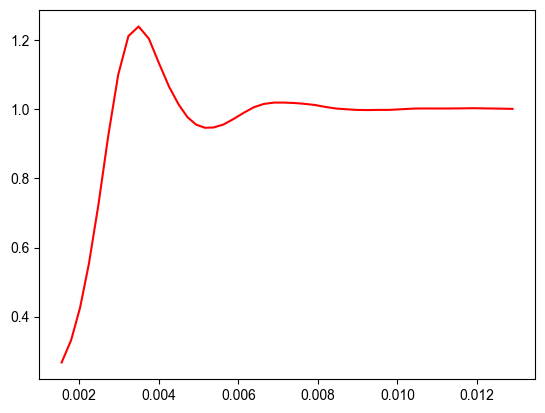

In [29]:
plt.plot(Q_1[Q_1<max(q)/d_HS_i],SQ_extracted[Q_1<max(q)/d_HS_i],'-r')
plt.show()